# Bayesian A/B Testing: Stop Early with Confidence

**Goal:** Show that Bayesian sequential testing lets you stop experiments early without sacrificing statistical rigor.

## Scenario: Landing Page Redesign

You're testing a new landing page design that applies principles of human attention:
- **Control:** Current design, 5% sign-up rate
- **Treatment:** New design, 6% sign-up rate (20% relative lift)
- **Traffic:** 500 visitors/day, split equally between variants (250 per group)

## The Problem with Traditional A/B Testing

Traditional (frequentist) testing:
- Pre-specify sample size based on power analysis
- **Cannot peek** at results without inflating false positive rate
- Must wait for full sample even if winner is obvious early

Bayesian sequential testing:
- Check results **anytime** without penalty
- Stop when confident enough (e.g., P(Treatment > Control) > 95%)
- Often stops much earlier with same confidence

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import myplotlib as my
from scipy import stats
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize, proportion_confint, proportions_ztest

import sys
sys.path.insert(0, '../src')
from bayesian_ab.simulation import simulate_ab_test
from bayesian_ab.plots import plot_cumulative_rates, plot_sequential_probability, plot_posteriors

## 1. Power Analysis: How Long for Traditional Testing?

First, let's determine the required sample size using traditional methods:
- **Minimum detectable effect:** 20% relative lift (5% → 6%)
- **Power:** 90% (high confidence we'll detect real effects)
- **Significance level:** α = 0.05

In [2]:
# True rates
true_p_control = 0.05
true_p_treatment = 0.07

# Power analysis parameters
power = 0.80
alpha = 0.05

# Calculate required sample size
effect_size = proportion_effectsize(true_p_treatment, true_p_control)
n_per_group = zt_ind_solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative='larger'
)

# Calculate experiment duration
daily_n = 250  # visitors per variant per day
n_days = int(np.ceil(n_per_group / daily_n))

print(f"Required sample size: {int(np.ceil(n_per_group))} per group")
print(f"Experiment duration: {n_days} days at {daily_n} visitors/day/variant")
print(f"Total visitors needed: {int(np.ceil(n_per_group * 2))}")

Required sample size: 1732 per group
Experiment duration: 7 days at 250 visitors/day/variant
Total visitors needed: 3464


## 2. Simulate the Experiment

Generate data as it would arrive day by day:

In [3]:
# Simulate daily data
data = simulate_ab_test(
    n_days=n_days,
    daily_n=daily_n,
    p_a=true_p_control,
    p_b=true_p_treatment,
    seed=510
)

# Add descriptive labels
data['design'] = data['variant'].map({'A': 'Control', 'B': 'New Design'})
data['signups'] = data['conversions']
data['visitors'] = data['n']

data[['day', 'design', 'visitors', 'signups']].head(10)

,day,design,visitors,signups
0,1,Control,250,13
1,1,New Design,250,12
2,2,Control,250,6
3,2,New Design,250,18
4,3,Control,250,13
5,3,New Design,250,24
6,4,Control,250,12
7,4,New Design,250,15
8,5,Control,250,15
9,5,New Design,250,12


## 3. Visualize Data Arrival

Calculate cumulative metrics to see how the data evolves:

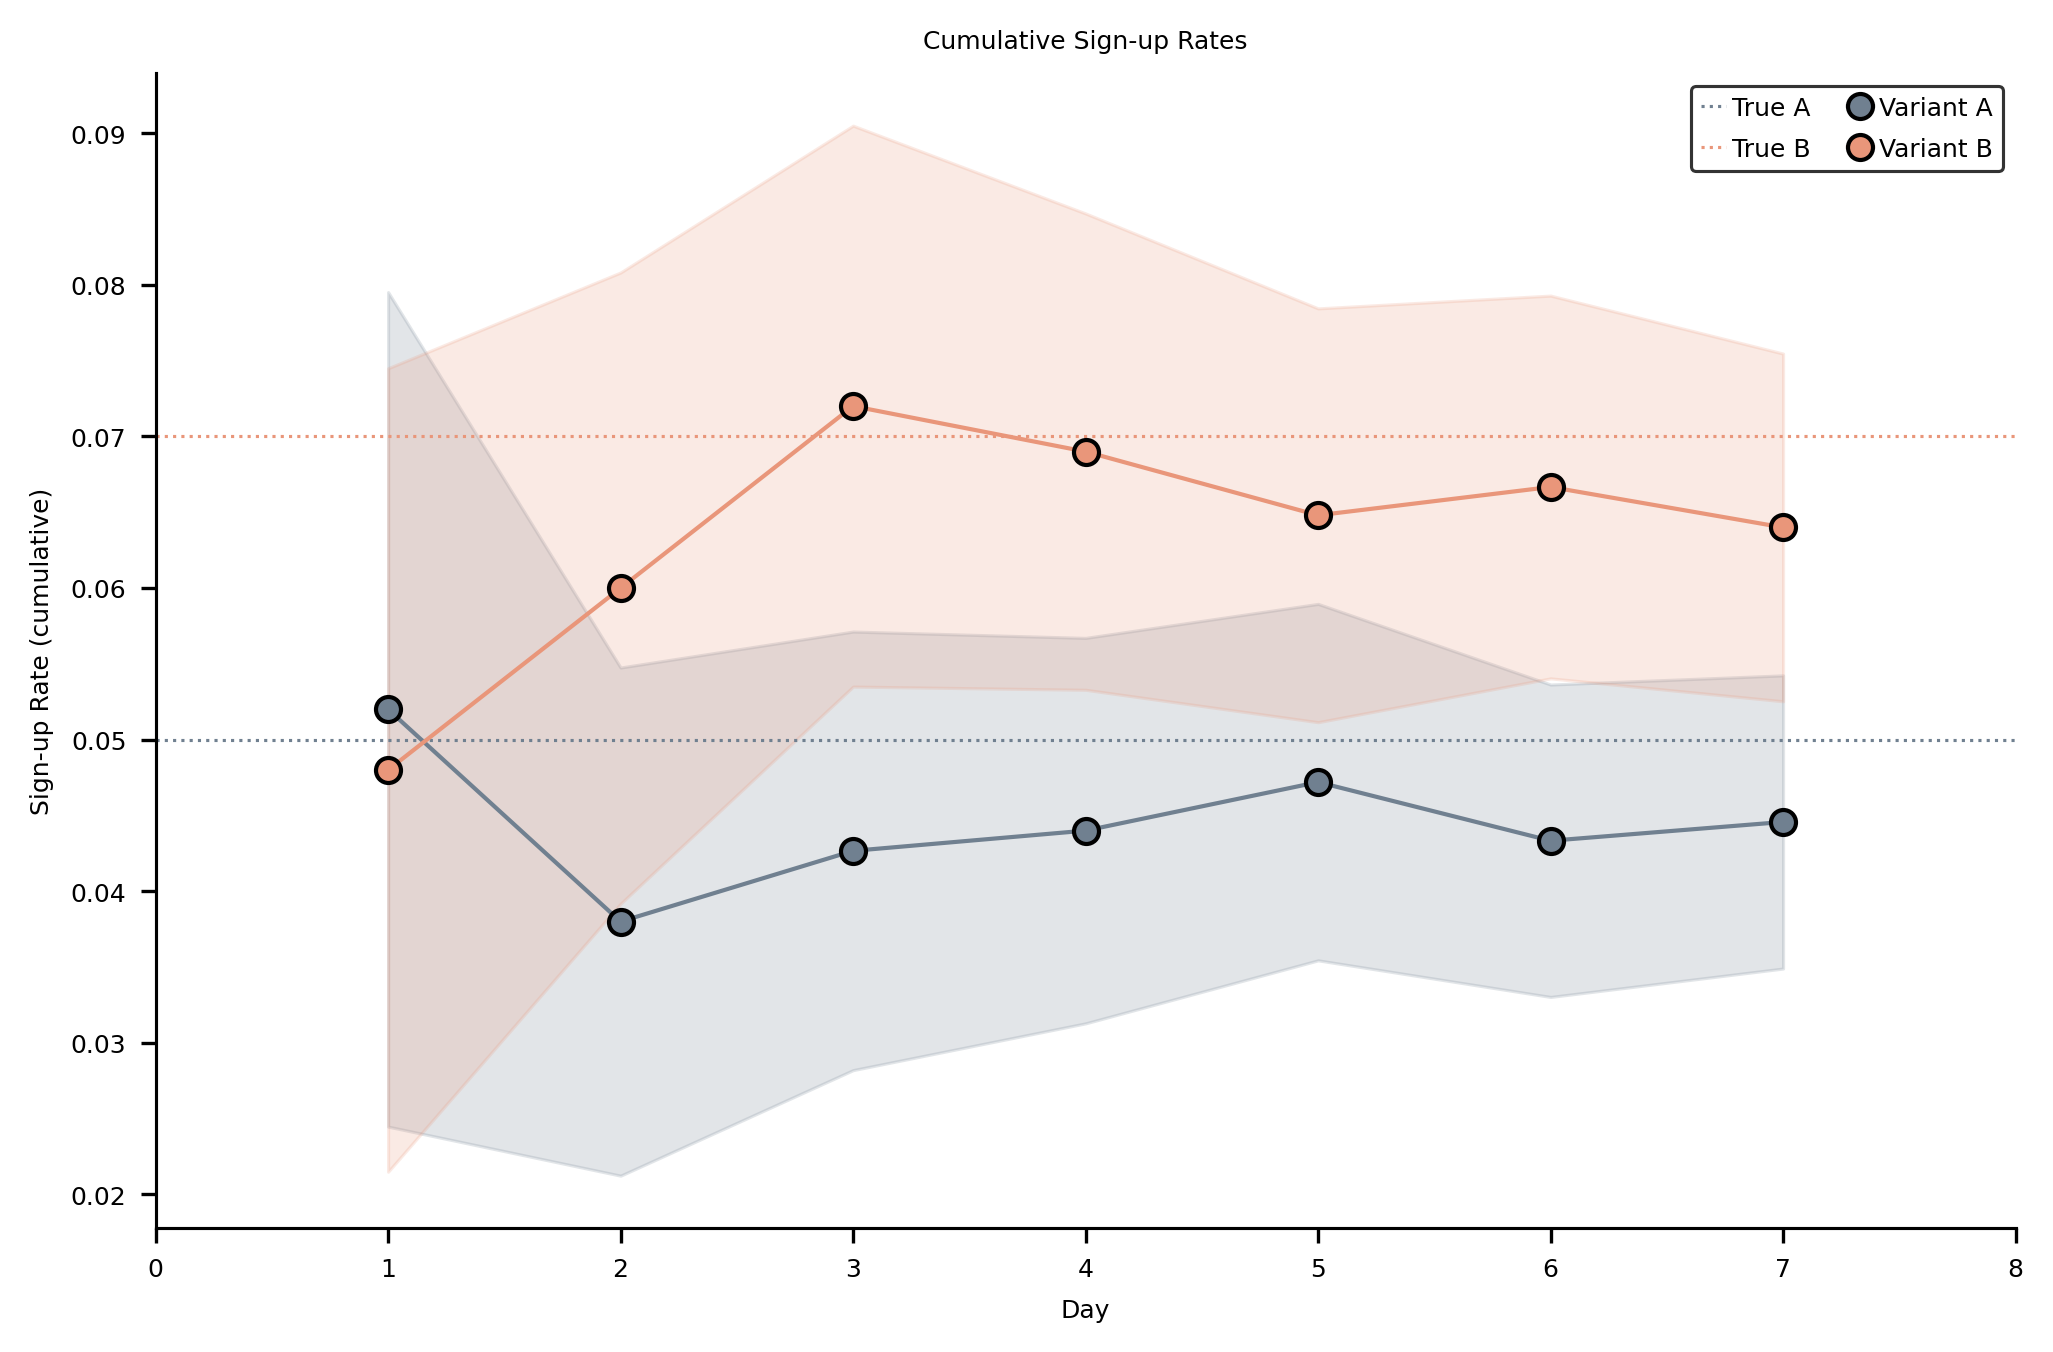

In [4]:
# Calculate cumulative statistics
cumulative = data.groupby(['variant']).apply(
    lambda x: pd.DataFrame({
        'day': x['day'],
        'cumulative_n': x['n'].cumsum(),
        'cumulative_conversions': x['conversions'].cumsum(),
    }), include_groups=False
).reset_index(drop=False).drop("level_1", axis=1)

cumulative["cumulative_rate"] = cumulative["cumulative_conversions"] / cumulative['cumulative_n']

# Add confidence intervals
wilson_ci = proportion_confint(
    count=cumulative["cumulative_conversions"],
    nobs=cumulative["cumulative_n"],
    method="normal",
    alpha=0.05
)
cumulative["ci_lower"] = wilson_ci[0]
cumulative["ci_upper"] = wilson_ci[1]

# Plot
true_rates = {'A': true_p_control, 'B': true_p_treatment}
plot_cumulative_rates(cumulative, true_rates, n_days)
plt.show()

## 4. Traditional Test: Must Wait Until the End

After collecting all data, we can run the test:

In [5]:
# Aggregate final data
final_data = data.groupby("variant")[["conversions", "n"]].sum()
final_data["rate"] = final_data["conversions"] / final_data["n"]

# Run traditional z-test
counts = [final_data.loc['B', 'conversions'], final_data.loc['A', 'conversions']]
nobs = [final_data.loc['B', 'n'], final_data.loc['A', 'n']]
z_stat, p_value = proportions_ztest(counts, nobs, alternative="larger")

print(f"Traditional Two-Proportion Z-Test (Full {n_days} Days):")
print(f"  Control rate:    {final_data.loc['A', 'rate']:.1%}")
print(f"  Treatment rate:  {final_data.loc['B', 'rate']:.1%}")
print(f"  Absolute lift:   {final_data.loc['B', 'rate'] - final_data.loc['A', 'rate']:.1%}")
print(f"  p-value:         {p_value:.4f}")
print(f"  Significant?     {p_value < alpha}")
print(f"\n  Total duration: {n_days} days")

Traditional Two-Proportion Z-Test (Full 7 Days):
  Control rate:    4.5%
  Treatment rate:  6.4%
  Absolute lift:   1.9%
  p-value:         0.0056
  Significant?     True

  Total duration: 7 days


## 5. Bayesian Sequential Analysis: Stop Early

### The Beta-Binomial Model

For each variant, we use conjugate Bayesian updating:
- **Prior:** Beta(1, 1) = Uniform (no prior knowledge)
- **Likelihood:** Binomial(signups | visitors, rate)
- **Posterior:** Beta(1 + signups, 1 + non-signups)

This conjugacy makes updating trivial - just add the data!

In [6]:
# Track results day by day
results = []

for day in range(1, n_days + 1):
    # Get cumulative data up to this day
    day_data = data[data['day'] <= day].groupby('variant')[['conversions', 'n']].sum()
    
    # Bayesian update: Beta(α, β) posterior
    signups_a = day_data.loc['A', 'conversions']
    visitors_a = day_data.loc['A', 'n']
    alpha_a = 1 + signups_a
    beta_a = 1 + (visitors_a - signups_a)
    
    signups_b = day_data.loc['B', 'conversions']
    visitors_b = day_data.loc['B', 'n']
    alpha_b = 1 + signups_b
    beta_b = 1 + (visitors_b - signups_b)
    
    # Calculate P(B > A) via Monte Carlo
    n_samples = 10000
    samples_a = np.random.beta(alpha_a, beta_a, n_samples)
    samples_b = np.random.beta(alpha_b, beta_b, n_samples)
    prob_b_better = np.mean(samples_b > samples_a)
    
    results.append({
        'day': day,
        'n_per_variant': day_data.loc['A', 'n'],
        'prob_b_better': prob_b_better,
        'should_stop': prob_b_better > 0.95
    })

results_df = pd.DataFrame(results)
results_df

,day,n_per_variant,prob_b_better,should_stop
0,1,250,0.4203,False
1,2,500,0.9464,False
2,3,750,0.9915,True
3,4,1000,0.9914,True
4,5,1250,0.9725,True
5,6,1500,0.9973,True
6,7,1750,0.9937,True


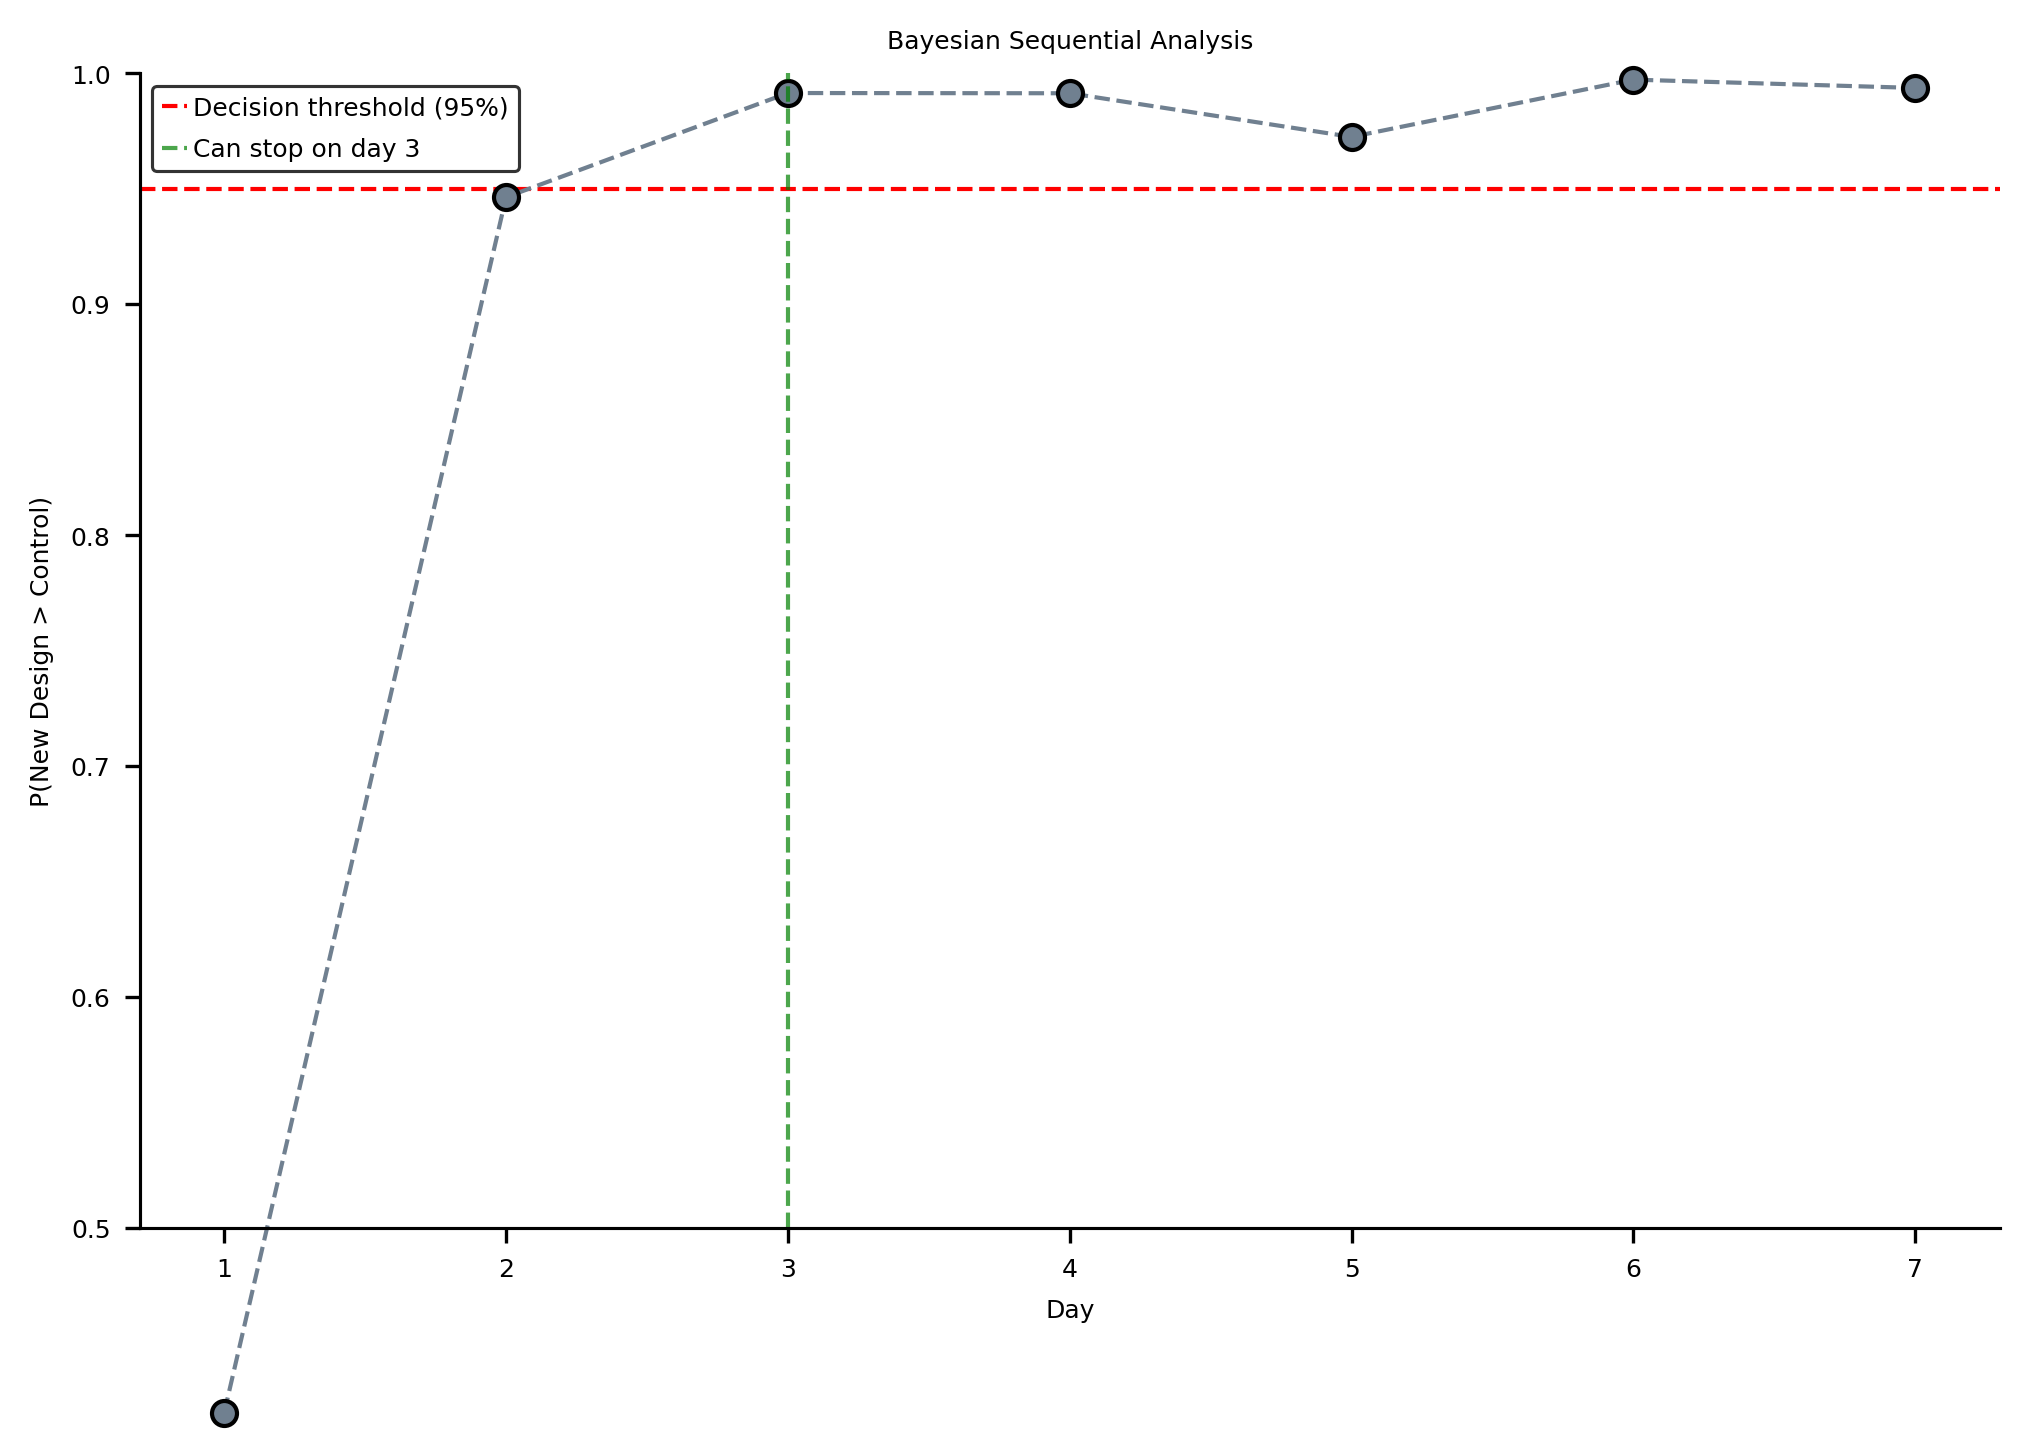


✓ Can stop on day 3 with 95% confidence
  vs. 7 days for traditional testing
  Savings: 57% reduction in experiment duration


In [7]:
# Visualize sequential analysis
plot_sequential_probability(results_df, threshold=0.95)
plt.show()

# Report stopping time
stop_day = results_df[results_df['should_stop']]['day'].min()
if pd.notna(stop_day):
    savings = 100 * (1 - stop_day/n_days)
    print(f"\n✓ Can stop on day {int(stop_day)} with 95% confidence")
    print(f"  vs. {n_days} days for traditional testing")
    print(f"  Savings: {savings:.0f}% reduction in experiment duration")
else:
    print("\nNeed more days to reach 95% confidence")

## 6. Posterior Distributions

What have we learned about the true conversion rates?

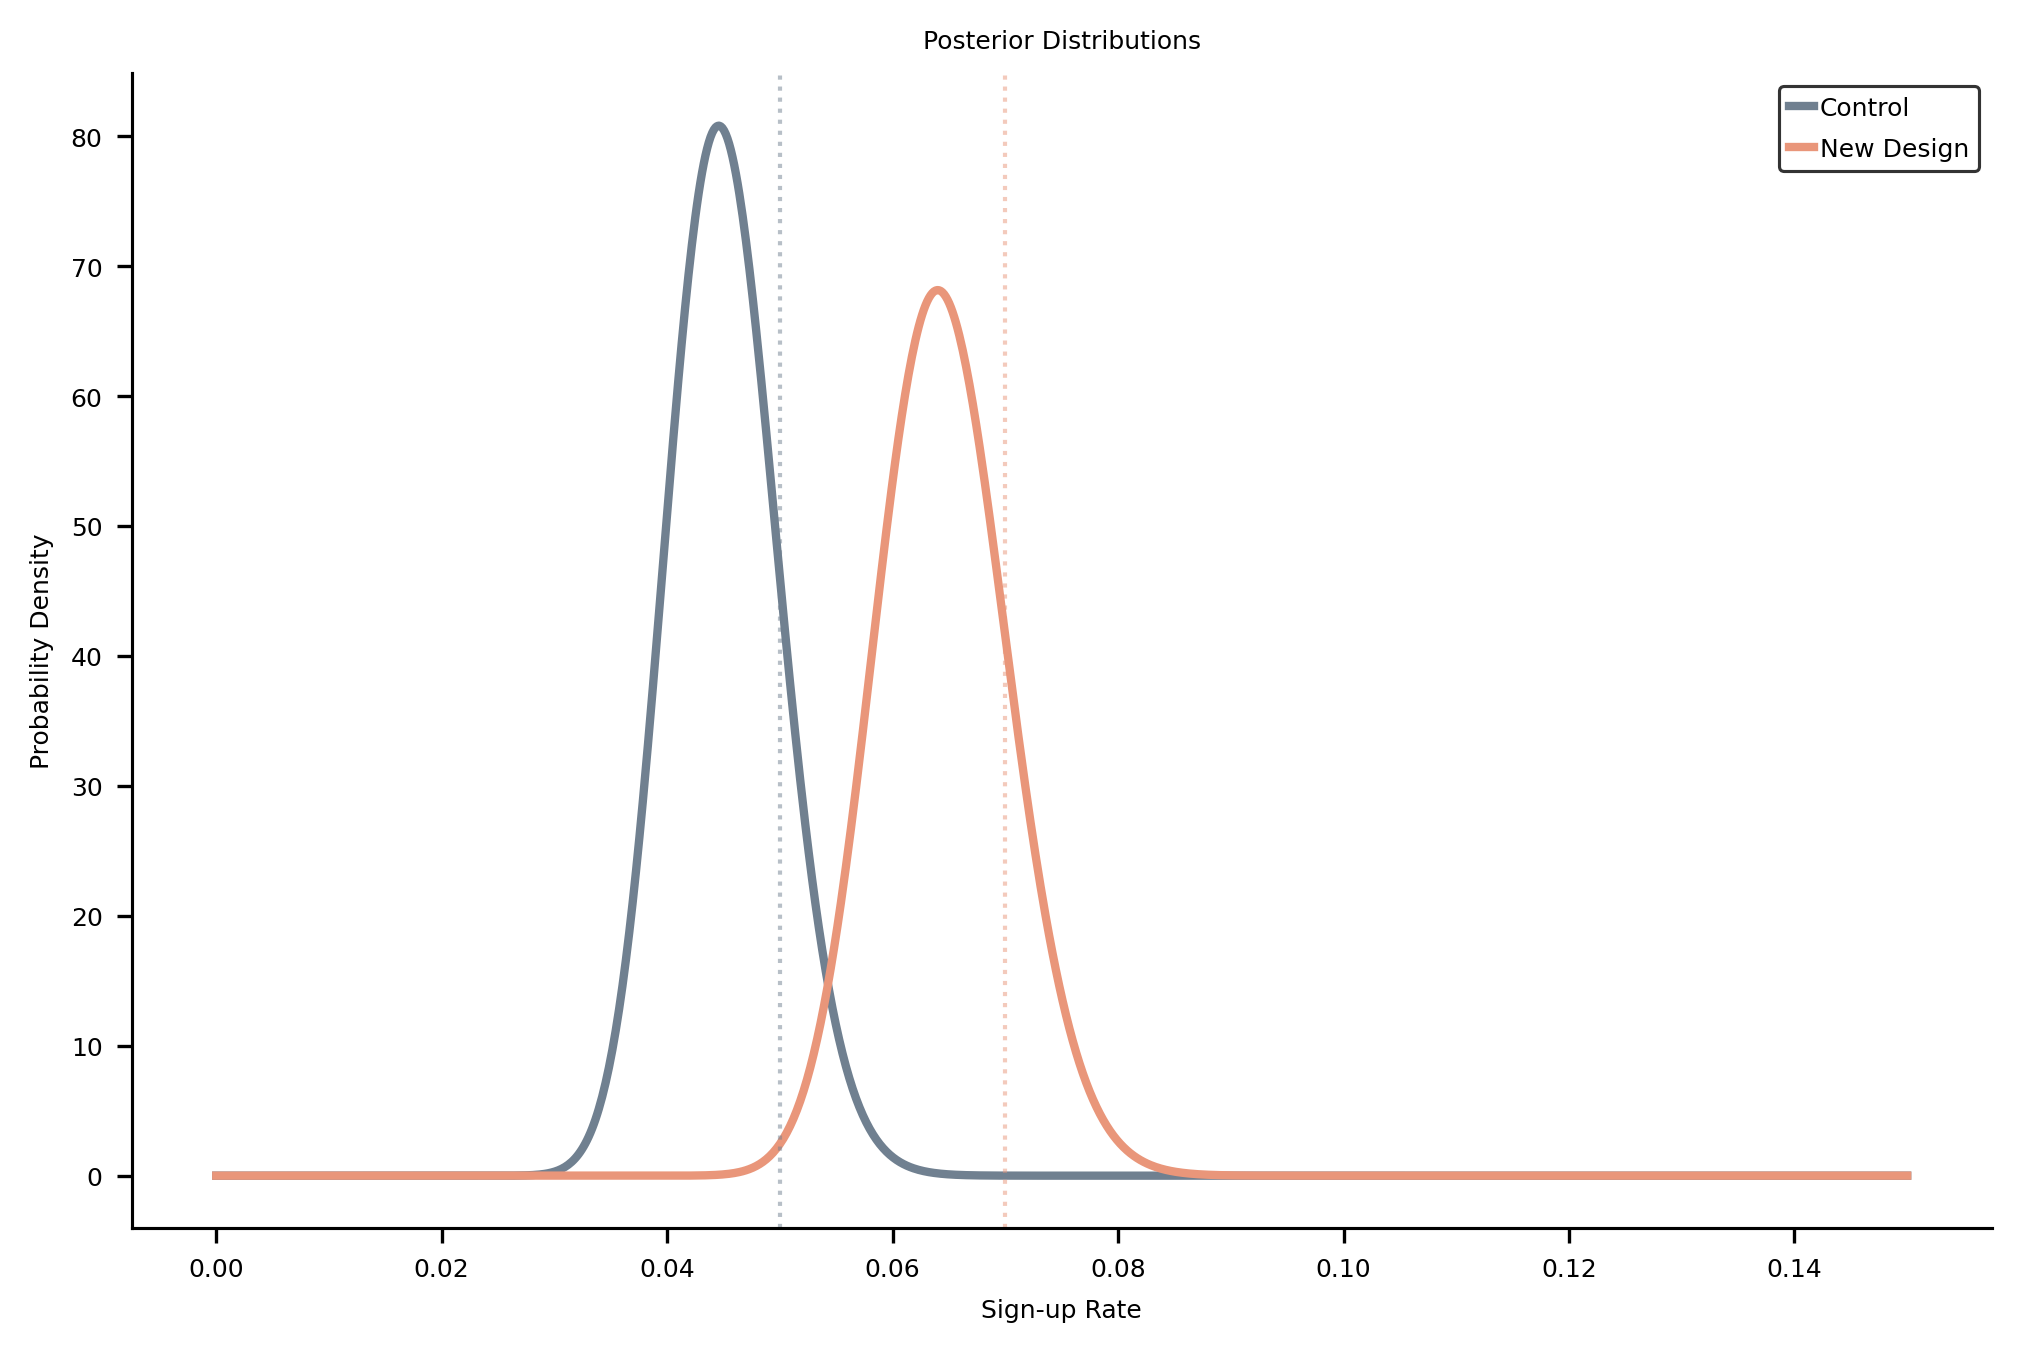

Posterior means:
  Control:     4.5%
  New Design:  6.4%

95% Credible Intervals:
  Control:     [3.6%, 5.5%]
  New Design:  [5.3%, 7.6%]


In [8]:
# Final posteriors
signups_a = final_data.loc['A', 'conversions']
visitors_a = final_data.loc['A', 'n']
alpha_a = 1 + signups_a
beta_a = 1 + (visitors_a - signups_a)

signups_b = final_data.loc['B', 'conversions']
visitors_b = final_data.loc['B', 'n']
alpha_b = 1 + signups_b
beta_b = 1 + (visitors_b - signups_b)

# Plot
plot_posteriors(alpha_a, beta_a, alpha_b, beta_b, true_rates)
plt.show()

# Summary statistics
print(f"Posterior means:")
print(f"  Control:     {alpha_a/(alpha_a + beta_a):.1%}")
print(f"  New Design:  {alpha_b/(alpha_b + beta_b):.1%}")
print(f"\n95% Credible Intervals:")
print(f"  Control:     [{stats.beta.ppf(0.025, alpha_a, beta_a):.1%}, {stats.beta.ppf(0.975, alpha_a, beta_a):.1%}]")
print(f"  New Design:  [{stats.beta.ppf(0.025, alpha_b, beta_b):.1%}, {stats.beta.ppf(0.975, alpha_b, beta_b):.1%}]")

## Key Takeaways

1. **Early stopping:** Bayesian methods can stop experiments earlier while maintaining confidence
2. **No peeking problem:** Check results anytime without inflating error rates
3. **Interpretable:** "95% probability new design is better" vs "p < 0.05"
4. **Rich information:** Full posterior distributions, not just yes/no decisions

## Next Steps

- Explore different priors (informative vs. non-informative)
- Add equivalence testing (ROPE: Region of Practical Equivalence)
- Simulate multiple experiments to validate false positive rates
- Compare different stopping rules and decision thresholds